In [ ]:
import pandas as pd
from pycoingecko import CoinGeckoAPI

# Initialiser le client CoinGeckoAPI
cg = CoinGeckoAPI()

# Paramètres pour la requête API
parameters = {
    'vs_currency': 'usd',
    'order': 'market_cap_desc',
    'per_page': 50,
    'page': 1,
    'sparkline': False,
    'locale': 'en'
}

# Récupérer les données du marché
coin_market_data = cg.get_coins_markets(**parameters)

# Convertir les données en DataFrame
df = pd.DataFrame(coin_market_data)

# Sélectionner les IDs des cryptomonnaies
top_100_coins = df[['id']].head(100)



In [ ]:
import pandas as pd
from pycoingecko import CoinGeckoAPI
import os

# Initialiser le client CoinGeckoAPI
cg = CoinGeckoAPI()

# Fonction pour récupérer les données historiques d'une cryptomonnaie
def fetch_historical_data(coin_id, start_date, end_date):
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())
    historical_data = cg.get_coin_market_chart_range_by_id(id=coin_id, vs_currency='usd',
                                                           from_timestamp=start_timestamp, to_timestamp=end_timestamp)
    prices = historical_data['prices']
    df_historical = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df_historical['timestamp'] = pd.to_datetime(df_historical['timestamp'], unit='ms')
    df_historical.set_index('timestamp', inplace=True)
    return df_historical

# Récupérer les données du marché pour le Top 50 des cryptomonnaies
market_data = cg.get_coins_markets(vs_currency='usd', order='market_cap_desc', per_page=50, page=1)
df_market = pd.DataFrame(market_data)
top_100_coins = df_market.head(100)

# Boucle pour récupérer les données historiques pour chaque cryptomonnaie
historical_dataframes = {}
for index, row in top_100_coins.iterrows():
    coin_id = row['id']
    print(f"Téléchargement des données pour {coin_id}.")
    df_historical = fetch_historical_data(coin_id, '2020-01-01', '2024-03-26')
    historical_dataframes[coin_id] = df_historical

# Créer un dossier pour stocker les fichiers CSV
data_dir = r'C:\Users\MasterPC\VSCODE\Cryptorobot\Backtest-Tools-V2\database\historical_data'
os.makedirs(data_dir, exist_ok=True)

# Enregistrer chaque DataFrame dans un fichier CSV
for coin_id, df_historical in historical_dataframes.items():
    file_path = os.path.join(data_dir, f"{coin_id}_historical_data.csv")
    df_historical.to_csv(file_path)

print("Les données historiques ont été téléchargées et enregistrées avec succès.")

In [23]:
import pandas as pd
import os

data_dir = r'C:\Users\MasterPC\VSCODE\Cryptorobot\Backtest-Tools-V2\database\historical_data'


# Dictionnaire pour stocker les DataFrames chargées
historical_dataframes = {}

# Liste des fichiers CSV dans le dossier
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Charger les données de chaque fichier CSV
for file in csv_files:
    coin_id = file.replace('_historical_data.csv', '')  # Extraire l'ID de la cryptomonnaie à partir du nom du fichier
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
    historical_dataframes[coin_id] = df

print("Les données historiques ont été chargées avec succès à partir des fichiers CSV.")

Les données historiques ont été chargées avec succès à partir des fichiers CSV.


In [24]:
import pandas as pd

def calculate_ema(prices, window):
    """Calculer la moyenne mobile exponentielle."""
    return prices.ewm(span=window, adjust=False).mean()

def calculate_mad_score(ema_short, ema_long):
    """Calculer le score MAD."""
    return ema_short / ema_long



In [ ]:
# Initialisation
# capital = 1500
# portfolio = {}  
# portfolio_history = []  
# short_window = 21 
# long_window = 200  

In [ ]:
# daily_scores = {} 

# for date in pd.date_range(start='2023-01-01', end='2024-03-20'):
#     scores = {}
#     for coin_id, df in historical_dataframes.items():
#         if date in df.index:
#             ema_short = calculate_ema(df.loc[:date, :coin_id], short_window).iloc[-1]
#             ema_long = calculate_ema(df.loc[:date, :coin_id], long_window).iloc[-1]
#             mad_score = calculate_mad_score(ema_short, ema_long)
#             scores[coin_id] = mad_score
#     daily_scores[date] = scores


In [47]:
import pandas as pd

short_ema_windows = range(15, 20, 1)  # Exemple : de 5 à 25 par pas de 5
long_ema_windows = range(45, 52, 1)
initial_wallet=1500
portfolio = {}
portfolio_history = []
start_period='2022-01-01'
end_period='2024-03-20'

config_performances = {}

for short_window in short_ema_windows:
    for long_window in long_ema_windows:
        
        capital = 1500
        portfolio = {}
        portfolio_history = []
        daily_scores = {}
        
        for date in pd.date_range(start=start_period, end=end_period):
            scores = {}
            for coin_id, df in historical_dataframes.items():
                if date in df.index:
                    # Assurez-vous que 'price' est le nom de la colonne contenant les prix dans chaque df
                    ema_short = calculate_ema(df['price'], short_window).iloc[-1]
                    ema_long = calculate_ema(df['price'], long_window).iloc[-1]
                    mad_score = calculate_mad_score(ema_short, ema_long)
                    scores[coin_id] = mad_score
            daily_scores[date] = scores

        for date, coins_scores in daily_scores.items():
            # Utiliser la dernière valeur non-NaN pour chaque coin comme score
            scalar_scores = {coin: score for coin, score in coins_scores.items()}
            
            # Trier les coins basés sur ces scores scalaires
            top_15_coins = sorted(scalar_scores, key=scalar_scores.get, reverse=True)[:15]

            # Vendre des actifs
            for coin in list(portfolio.keys()):
                if date in historical_dataframes[coin].index:
                    current_price = historical_dataframes[coin].loc[date, 'price']
                    ema_long = calculate_ema(historical_dataframes[coin].loc[:date, 'price'], long_window).iloc[-1]
                    
                    if current_price < ema_long or coin not in top_15_coins:
                        capital += portfolio[coin] * current_price  # Mise à jour du capital après vente
                        del portfolio[coin]  # Suppression du portfolio

            # Calculer l'allocation par actif à acheter
            coins_to_buy = [coin for coin in top_15_coins if coin not in portfolio.keys()]
            if coins_to_buy:
                allocation_per_coin = capital / len(coins_to_buy) if capital > 0 else 0

                # Acheter des actifs
                for coin in coins_to_buy:
                    if date in historical_dataframes[coin].index:
                        coin_price = historical_dataframes[coin].loc[date, 'price']
                        ema_long = calculate_ema(historical_dataframes[coin].loc[:date, 'price'], long_window).iloc[-1]
                        
                        if coin_price >= ema_long and capital >= allocation_per_coin:
                            quantity_to_buy = allocation_per_coin / coin_price
                            portfolio[coin] = quantity_to_buy  # Mise à jour de la quantité
                            capital -= allocation_per_coin  # Déduction du capital utilisé pour l'achat

            # Mise à jour de la valeur du portfolio
            portfolio_value = sum(historical_dataframes[coin].loc[date, 'price'] * quantity for coin, quantity in portfolio.items() if date in historical_dataframes[coin].index) + capital
            portfolio_history.append((date, portfolio_value))
            
        final_portfolio_value = portfolio_history[-1][1] if portfolio_history else capital
        if capital != 0:
            performance = (final_portfolio_value - initial_wallet) / initial_wallet * 100
        else:
            performance = -100 
        config_performances[(short_window, long_window)] = performance
        
best_config = max(config_performances, key=config_performances.get)
best_performance = config_performances[best_config]
print(f"Meilleure configuration: EMA courte = {best_config[0]}, EMA longue = {best_config[1]}")
print(f"Meilleure performance: {best_performance:.2f} %")

Meilleure configuration: EMA courte = 17, EMA longue = 50
Meilleure performance: 415.66 %


Capital initial: 1500 $
--- Informations Générales ---
Début du backtest: 2022-01-01
Fin du backtest: 2024-03-20
Capital final: 7335.30 $
Performance: 389.02 %
Pire drawdown: -46.68 %


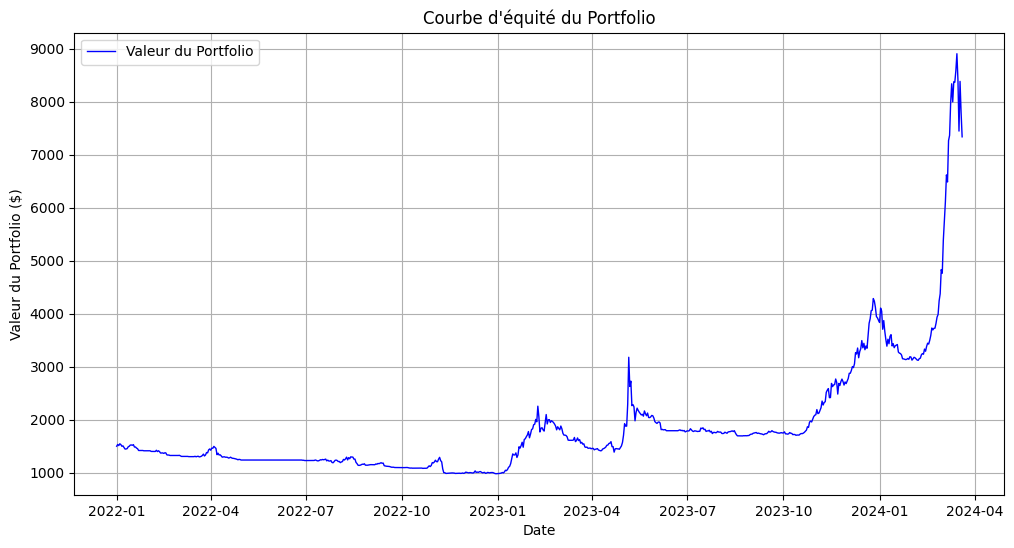

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Assurez-vous que df_portfolio_history est créé après le backtest avec la meilleure configuration d'EMA
df_portfolio_history = pd.DataFrame(portfolio_history, columns=['Date', 'Portfolio Value'])
df_portfolio_history['Date'] = pd.to_datetime(df_portfolio_history['Date'])
df_portfolio_history.set_index('Date', inplace=True)

if not df_portfolio_history.empty:
    # Capital initial et final 
    initial_wallet = 1500
    final_wallet = df_portfolio_history['Portfolio Value'].iloc[-1]

    # Correction du calcul de la performance pour utiliser initial_wallet
    performance = (final_wallet - initial_wallet) / initial_wallet * 100

    # Calcul du Drawdown Maximal
    peak_values = df_portfolio_history['Portfolio Value'].cummax()
    drawdowns = (df_portfolio_history['Portfolio Value'] - peak_values) / peak_values
    worst_drawdown = drawdowns.min() * 100

    # Affichage des résultats
    
    print(f"Capital initial: {initial_wallet} $")
    print("--- Informations Générales ---")
    print(f"Début du backtest: {start_period}")
    print(f"Fin du backtest: {end_period}")
    print(f"Capital final: {final_wallet:.2f} $")
    print(f"Performance: {performance:.2f} %")
    print(f"Pire drawdown: {worst_drawdown:.2f} %")
    
    # Graphique
    plt.figure(figsize=(12, 6))
    plt.plot(df_portfolio_history.index, df_portfolio_history['Portfolio Value'], label='Valeur du Portfolio', color='blue', linewidth=1)
    plt.title('Courbe d\'équité du Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Valeur du Portfolio ($)')
    ax = plt.gca()  # Obtient l'axe actuel
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Le DataFrame est vide. Assurez-vous que `portfolio_history` contient des données avant de continuer.")
